# Harmony

In [5]:
import os
import csv
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# for prototyping piano-roll visualizations
import pretty_midi as pm
import librosa
import librosa.display
import mir_eval
import mir_eval.display

import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('..')

from eval.metrics.benchmarks import *
from eval.metrics.dynamics import *
from eval.metrics.harmony import *
from eval.metrics.articulation import *
from eval.metrics.timing import *

# from config import *
from helpers.analysis import *

# To avoid the following error when running mir_eval.display.piano_roll later:
# AttributeError: '_process_plot_var_args' object has no attribute 'prop_cycler'
# I rolled back matplotlib to 3.7 as per https://github.com/librosa/librosa/issues/1763#issuecomment-1742120524

print(matplotlib.__version__)
assert matplotlib.__version__ == '3.7.0', 'mir_eval.display.piano_roll needs matplotlib @ 3.7.0'

3.7.0


We will use the handcrafted example henceforth

In [6]:
ref_midi = '../data/poster_example/mozart_example_gt.mid'
pred_midi = '../data/poster_example/mozart_example_tr.mid'

Load and visualize the example MIDI pair along with the illustration of the selected MIM: **harmony**

In [8]:
ref_perf = pt.load_performance_midi(ref_midi)
pred_perf = pt.load_performance_midi(pred_midi)

harmony_metrics = harmony_metrics_from_perf(ref_perf, pred_perf)

print(harmony_metrics.dtype)
print(harmony_metrics)

[('cloud_diameter_corr', '<f8'), ('cloud_momentum_corr', '<f8'), ('tensile_strain_corr', '<f8')]
[(0.68374109, 0.45588411, 0.3652259)]


break it down

In [ ]:
# Default window and step size parameters from harmony_metrics_from_perf
ws = 5
ss = 1

ref_note_array = ref_perf.note_array()

# get tonal tension func and interpolation function
onsets_harm, ref_cd, cd_func = get_tonal_tension_feature_func(
    ref_note_array, 'cloud_diameter', ws, ss, return_onsets=True)
ref_cm, cm_func = get_tonal_tension_feature_func(
    ref_note_array, 'cloud_momentum', ws, ss)

# get tonal tension and interp func for prediction
pred_note_array = pred_perf.note_array()

pred_cd, pred_cd_func = get_tonal_tension_feature_func(
    pred_note_array, 'cloud_diameter', ws, ss)
pred_cm, pred_cm_func = get_tonal_tension_feature_func(
    pred_note_array, 'cloud_momentum', ws, ss)
pred_cd = pred_cd_func(onsets_harm)
pred_cm = pred_cm_func(onsets_harm)

cd_corr = np.corrcoef(ref_cd, pred_cd)[0, 1]
cm_corr = np.corrcoef(ref_cm, pred_cm)[0, 1]

cd_corr, cm_corr

(0.6837410868712887, 0.45588410750786545)

Plot

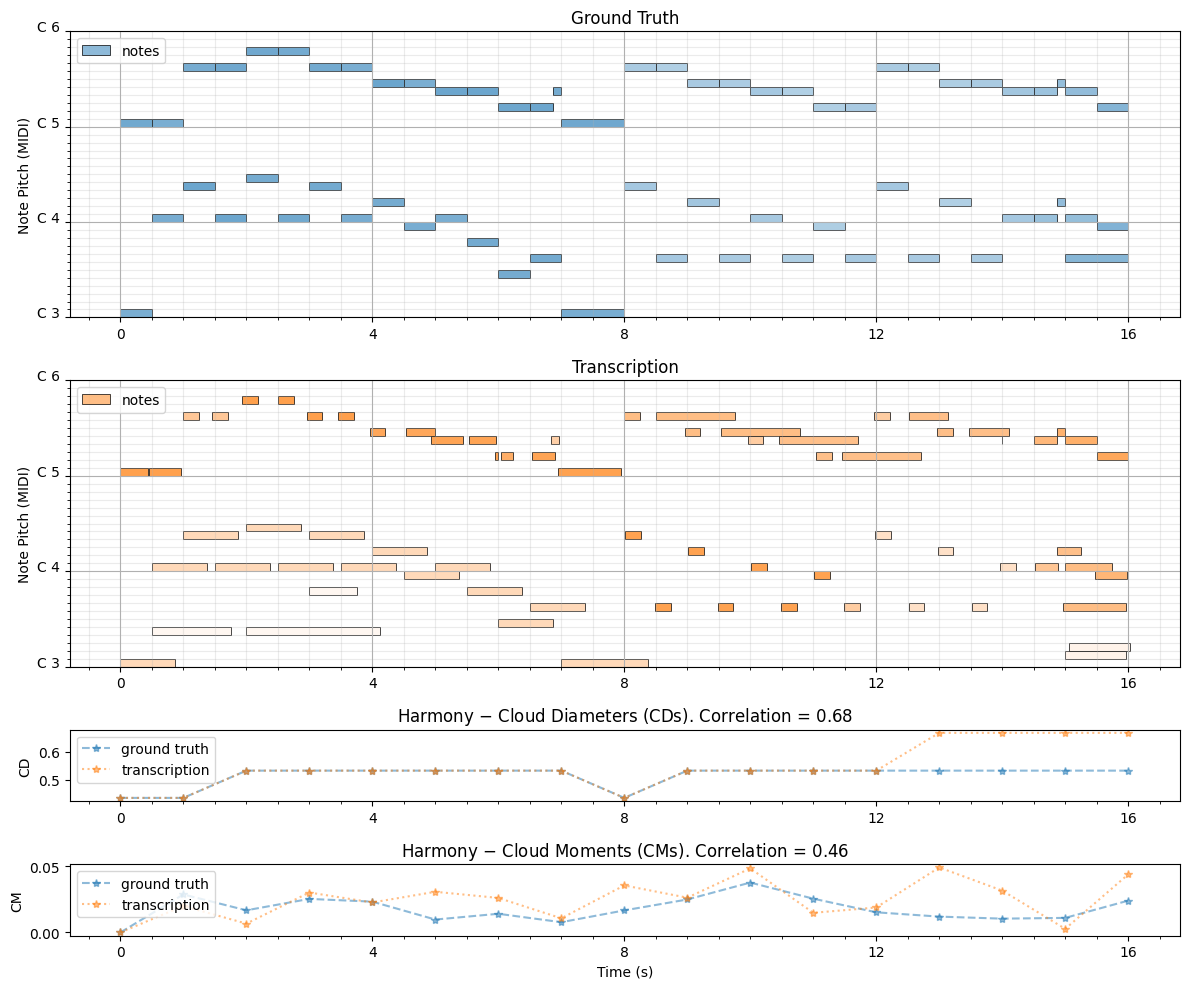

In [ ]:
def get_rgba(color, alpha=0.5):
    import matplotlib.colors as mcolors
    if not hasattr(alpha, '__iter__'):
        return mcolors.to_rgb(color) + (alpha,)
    return [mcolors.to_rgb(color) + (a,) for a in alpha]

def plot_together_pianorolls_IOIs(
        ref_note_array, pred_note_array,
        onsets_harm, ref_cd, ref_cm, pred_cd, pred_cm,
        title='',
        ):
    # plot the melody, bass, and middle lines with separate colors, velocity as alpha
    fig, axs = plt.subplots(4, 1, figsize=(16-4, 8+2), sharex=True, gridspec_kw={'height_ratios': [4, 4, 1, 1]})
    # kwargs forwarded to Collection: https://matplotlib.org/3.7.0/api/collections_api.html#matplotlib.collections.Collection

    lw = 0.5
    alpha = 0.5

    # ground truth
    ax = axs[0]

    mir_eval.display.piano_roll([], midi=[],
        label='notes', facecolor=get_rgba('tab:blue', alpha), edgecolor='black', linewidth=lw, linestyle='-', hatch=None, ax=ax)
    for note in ref_note_array:
        ax.add_patch(plt.Rectangle(
            (note['onset_sec'], note['pitch']), note['duration_sec'], 1.0, facecolor=get_rgba('tab:blue', note['velocity'] / 127.),
            edgecolor='black', linewidth=lw, linestyle='-', hatch=None))
    
    # transcription
    ax = axs[1]

    mir_eval.display.piano_roll([], midi=[],
        label='notes', facecolor=get_rgba('tab:orange', alpha), edgecolor='black', linewidth=lw, linestyle='-', hatch=None, ax=ax)
    for note in pred_note_array:
        ax.add_patch(plt.Rectangle(
            (note['onset_sec'], note['pitch']), note['duration_sec'], 1.0, facecolor=get_rgba('tab:orange', note['velocity'] / 127.),
            edgecolor='black', linewidth=lw, linestyle='-', hatch=None))

    for ax in [axs[0], axs[1]]:
        ax.grid(True, which='major')
        ax.grid(True, which='minor', alpha=0.25)
        noterange=(pm.note_name_to_number('C3'), pm.note_name_to_number('C6'))
        ax.set_ybound(lower=noterange[0], upper=noterange[1])
        ax.legend(loc='upper left')

        mir_eval.display.ticker_notes(ax=ax) # replace midi pitch numbers with note names
        ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=12.0)) # major tick each 12 semitones (1 octave)
        ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=4.0)) # major tick [seconds]
        ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(base=0.5)) # minor tick [seconds]
        ax.tick_params(labelbottom=True, labelleft=True)
        ax.set_ylabel('Note Pitch (MIDI)');
        # ax.set_xlabel('Time (s)');
    
    axs[0].set_title('Ground Truth');
    axs[1].set_title('Transcription');

    # CD/CM - Harmony Metrics Correlations
    cd_corr = np.corrcoef(ref_cd, pred_cd)[0, 1]
    cm_corr = np.corrcoef(ref_cm, pred_cm)[0, 1]

    ax = axs[2]
    ax.plot(onsets_harm, ref_cd, alpha=.5, linestyle='--', marker='*', label='ground truth')
    ax.plot(onsets_harm, pred_cd, alpha=.5, linestyle=':', marker='*', label='transcription')
    ax.tick_params(labelbottom=True, labelleft=True)
    ax.set_ylabel('CD')
    ax.set_title(f'Harmony $-$ Cloud Diameters (CDs). Correlation = {cd_corr:.2f}')
    ax.legend(loc='upper left')

    ax = axs[3]
    ax.plot(onsets_harm, ref_cm, alpha=.5, linestyle='--', marker='*', label='ground truth')
    ax.plot(onsets_harm, pred_cm, alpha=.5, linestyle=':', marker='*', label='transcription')
    ax.tick_params(labelbottom=True, labelleft=True)
    ax.set_ylabel('CM')
    ax.set_title(f'Harmony $-$ Cloud Moments (CMs). Correlation = {cm_corr:.2f}')
    ax.legend(loc='upper left')

    ax.set_xlabel('Time (s)');

    fig.tight_layout()
    
    return fig, axs

fig, axs = plot_together_pianorolls_IOIs(
    ref_note_array, pred_note_array,
    onsets_harm, ref_cd, ref_cm, pred_cd, pred_cm,
    title='Running example for illustrating computation of our Musically Informed Metrics')
# supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff, webp
fig.savefig('../poster/poster_fig3_harmony.pdf', bbox_inches='tight')